In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

### Create Environment

In [3]:
# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

### Environment Design

In [4]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params)

In [5]:
env_design.run_n_episodes(n_episodes=0,
                          bayesian_regret_how=None,
                          candidate_environments_args=None)

env_design.save("big_small")

Started episode 0.
Finished episode 0.


### Inference - load observations and initialize posterior inference class.

In [6]:
import pickle

experiment_name = os.path.join("checkpoints", "big_small", "27.02.2024", "11:20:29")

def load_file(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_name = experiment_name
big_small_experiment = load_file(file_name)

In [7]:
pos_inference = PosteriorInference(expert_trajectories=big_small_experiment["all_observations"],
                                    resolution = 15)

### Calculate Posterior Distribution.

In [8]:
pos_inference.calculate_posterior(num_episodes=1)

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.


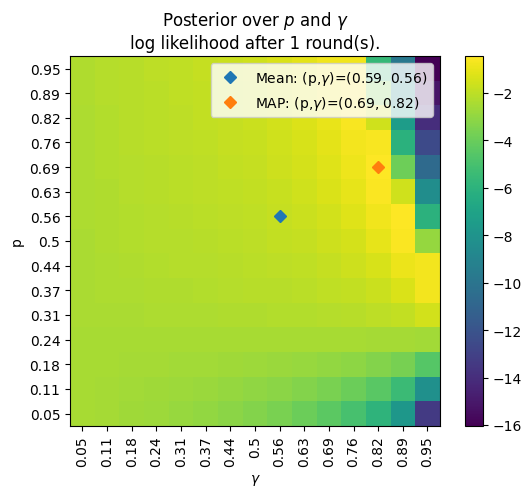

In [9]:
pos_inference.plot_posterior(episode=1)

### Calculate Region of Interest

In [10]:
likelihood = np.exp(pos_inference.posterior_distribution["episode=1"])
likelihood = likelihood / np.sum(likelihood)

likelihood

region_of_interest = []
idx = 1
current_mass = 0
ROI_mass = 0.95

flat_likelihood = likelihood.flatten()
flat_likelihood_sorted = np.sort(flat_likelihood)

#Add mass of n-th largest element until we reach the ROI mass.
while True:

    if current_mass > ROI_mass:
        break

    current_mass += flat_likelihood_sorted[-idx]
    region_of_interest.append(np.where(likelihood == flat_likelihood_sorted[idx]))
    idx += 1

#Change to Numpy Array for easier indexing
region_of_interest = np.array(region_of_interest).reshape(idx-1,2)

### Calculate Behavior Map

In [11]:
import src.utils.behavior_map as bm

from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment


custom_world = make_world(height=env_design.base_environment.N,
                          width=env_design.base_environment.M,
                          rewards=env_design.base_environment.R_true,
                          absorbing_states=env_design.base_environment.goal_states,
                          wall_states=env_design.base_environment.wall_states)

/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [12]:
probs = np.linspace(0.3, 0.95, 15)
gammas = np.linspace(0.5, 0.95, 15)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs
)

First time!


In [13]:
from copy import deepcopy
import matplotlib.pyplot as plt


class AgnosticsBM():

    def __init__(self, 
                 environment,
                 behavior_map_environment):
        
        self.environment = environment
        self.perturbed_environment = deepcopy(self.environment)
        self.behavior_map_base_environment = behavior_map_environment
        self.behavior_map_perturbed_environment = None
        self.prop_dominant_policy = []
        self.prop_subdominant_policy = []
        self.prop_unreasonable_policy = []
        self.perturbed_environments = {}

        #Get statistics of base environment.
        self.calculate_behavior_map_stats(behavior_map=self.behavior_map_base_environment)


    def calculate_behavior_map_stats(self, behavior_map):

        '''
        Determine reasonable, unreasonable and dominant policies in the behavior map.
        '''

        #Reasonable policies are all policies that don't stay in the start state. Unreasonable policies stay in the start state.
        reasonable_policies_idx = [p for p, states in behavior_map.pidx2states.items() if states[-1] in self.environment.goal_states]
        unreasonable_policies_idx = [p for p, states in behavior_map.pidx2states.items() if states[-1] not in self.environment.goal_states]

        #Number of different policies.
        behaviors_flattened = behavior_map.data.flatten()
        n_behaviors = len(behaviors_flattened)

        #Number of reasonable policies.
        n_reasonable_behaviors = np.sum(np.isin(behaviors_flattened, reasonable_policies_idx))
        n_unreasonable_behaviors = np.sum(np.isin(behaviors_flattened, unreasonable_policies_idx))

        #Count the number of times each policy is chosen.
        behavior, counts = np.unique(behaviors_flattened, return_counts=True)
        behavior_counts = dict(zip(behavior, counts))

        #Dominant policy is the policy with the most counts, e.g. that covers the largest proportion of the Behavior Map.
        # Remove all unreasonable policies from the counts.
        for unreasonable_policy in unreasonable_policies_idx:
            behavior_counts.pop(unreasonable_policy, None)
        dominant_policy = max(behavior_counts, key=behavior_counts.get)

        #Subdominant policies are all policies that are a) not dominant and b) not unreasonable.
        n_dominant_behaviors = behavior_counts[dominant_policy]
        n_subdominant_behaviors = n_reasonable_behaviors - n_dominant_behaviors

        #Determine proportion of BM that each policy type covers.
        prop_dominant_policy = n_dominant_behaviors / n_behaviors
        prop_subdominant_policy = n_subdominant_behaviors / n_behaviors
        prop_unreasonable_policy = n_unreasonable_behaviors / n_behaviors

        #Get a rollout of the dominant policy.
        dominant_states = behavior_map.pidx2states[dominant_policy]

        return prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states

    def perturb_transition_dynamics(self, states):

        '''
        We want to change the transition dynamics, such that prop_dominant_policy decreases and prop_subdominant_policy increases while prop
        _unreasonable_policy remains small.
        We can do this by changing the reward function and transition dynamics such that the dominant policy becomes less attractive and the subdominant
        poicies become more attractive. To this end, we insert walls/ death states along the rollouts of the dominant policy and remove walls/death states
        from the rollouts of the subdominant policies. This will make the dominant policy less attractive and the subdominant policies more attractive.
        '''
        #Get a random state from the dominant policy to insert a wall into. Remove goal states and start state.
        random_state_from_dominant = np.random.choice(list(states), size = 1)
        random_state_from_dominant = np.setdiff1d(random_state_from_dominant, env_design.base_environment.goal_states)
        #TODO: start state should be flexible, not 0.
        random_state_from_dominant = np.setdiff1d(random_state_from_dominant, [0])

        #Insert walls into the transition matrix along the rollouts of the dominant policy and update transition function.
        T_new = insert_walls_into_T(T=self.perturbed_environment.T_true, wall_indices=random_state_from_dominant)
        self.perturbed_environment.wall_states = np.append(self.perturbed_environment.wall_states, random_state_from_dominant)
        self.perturbed_environment.T_true = T_new
        print(f"Perturbed transition dynamics. Inserted a wall into state {random_state_from_dominant}.")

    
    def perturb_reward_function(self, states):

        '''
        Change reward function along dominant rollout of dominant.
        '''
        #Get a random state from the dominant policy to insert a wall into. Remove goal states and start state.
        random_state_from_dominant = np.random.choice(list(states), size = 1)
        random_state_from_dominant = np.setdiff1d(random_state_from_dominant, env_design.base_environment.goal_states)
        #TODO: start state should be flexible, not prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states0.
        random_state_from_dominant = np.setdiff1d(random_state_from_dominant, [0])
        #Insert negative reward into the transition matrix along the rollouts of the dominant policy.
        R_new = self.perturbed_environment.R_true.copy()
        R_new[random_state_from_dominant] = -1

        self.perturbed_environment.R_true = R_new
        print(f"Perturbed reward function. Inserted a negative reward into state {random_state_from_dominant}.")

    
    def perturb_environment(self, n_iterations: int,
                            plot_bmap: bool = False,):

        '''
        Perturb the environment such that the dominant policy becomes less attractive and the subdominant policies become more attractive.
        '''

        #Statistics of Base Environment.
        prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states = self.calculate_behavior_map_stats(behavior_map=self.behavior_map_base_environment)
        self.generate_behavior_map()

        
        for iteration in range(n_iterations):

            #Calculate statistics of current behavior map, e.g. what is the dominant policy, how much of the Behavior Map is covered
            #by the dominant policy, how much of the Behavior Map is covered by unreasonable policies.

            #Perturb the reward function.
            self.perturb_reward_function(dominant_states)

            #Perturb the transition function.
            self.perturb_transition_dynamics(dominant_states)

            #Generate new Behavior Map.
            self.generate_behavior_map(plot_bmap=plot_bmap)

            #Calculate statistics of new behavior map.
            prop_dominant_policy, prop_subdominant_policy, prop_unreasonable_policy, dominant_states = self.calculate_behavior_map_stats(behavior_map=self.behavior_map_perturbed_environment)

            #Append statistics to list.
            self.prop_dominant_policy.append(prop_dominant_policy)
            self.prop_subdominant_policy.append(prop_subdominant_policy)
            self.prop_unreasonable_policy.append(prop_unreasonable_policy)

            #Store perturbed environment.
            self.perturbed_environments[f"iteration_{iteration}"] = self.perturbed_environment


    def generate_behavior_map(self,
                              plot_bmap: bool = False):

        '''
        Calculate the behavior map.
        '''

        self.world = make_world(height=self.perturbed_environment.N,
                          width=self.perturbed_environment.M,
                          rewards=self.perturbed_environment.R_true,
                          absorbing_states=self.perturbed_environment.goal_states,
                          wall_states=self.perturbed_environment.wall_states)

        self.behavior_map_perturbed_environment = bm.plot_bmap(
            world=self.world,
            gammas=gammas,
            probs=probs,
            plot=plot_bmap
        )

    
    def plot_behavior_map(self, environment, gammas, probs):

        '''
        Plot the behavior map of an environment for parameter bounds gammas and probs.
        '''

        self.world = make_world(height=environment.N,
                          width=environment.M,
                          rewards=environment.R_true,
                          absorbing_states=environment.goal_states,
                          wall_states=environment.wall_states)

        self.behavior_map_perturbed_environment = bm.plot_bmap(
            world=self.world,
            gammas=gammas,
            probs=probs,
            plot=True
        )

    def plot_props_over_time(self, iteration):

        '''
        Plot the proportion of the Behavior Map covered by the dominant policy, subdominant policy and unreasonable policy over time.
        '''
        _iterations = np.arange(0, iteration+1, 1.0)
        plt.plot(_iterations, self.prop_dominant_policy[:iteration+1], "x-", color="green", label="Dominant Policy")
        plt.plot(_iterations, self.prop_subdominant_policy[:iteration+1], "o-", color="red", label="Subdominant Policy")
        plt.plot(_iterations, self.prop_unreasonable_policy[:iteration+1], "s-", color="blue", label="Unreasonable Policy")
        plt.xlabel("Iteration")
        plt.ylabel("Proportion of Behavior Map")
        plt.legend()
        plt.title("Proportion of Behavior Map covered by Dominant, Subdominant and Unreasonable Policies over Time")
        plt.xticks(_iterations)
        plt.show()

        del _iterations

In [14]:
agnostics_bm = AgnosticsBM(environment=env_design.base_environment,behavior_map_environment=out)

First time!
Perturbed reward function. Inserted a negative reward into state [15].
Perturbed transition dynamics. Inserted a wall into state [43].
First time!
Perturbed reward function. Inserted a negative reward into state [25].
Perturbed transition dynamics. Inserted a wall into state [18].
First time!
Perturbed reward function. Inserted a negative reward into state [].
Perturbed transition dynamics. Inserted a wall into state [12].
First time!
Perturbed reward function. Inserted a negative reward into state [].
Perturbed transition dynamics. Inserted a wall into state [2].
First time!
Perturbed reward function. Inserted a negative reward into state [39].
Perturbed transition dynamics. Inserted a wall into state [30].
First time!


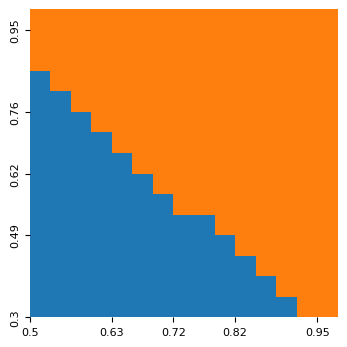

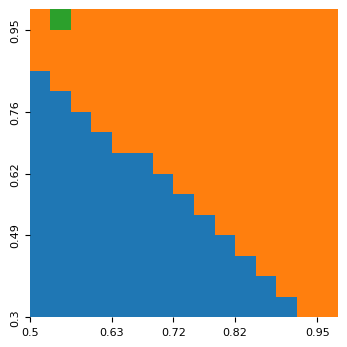

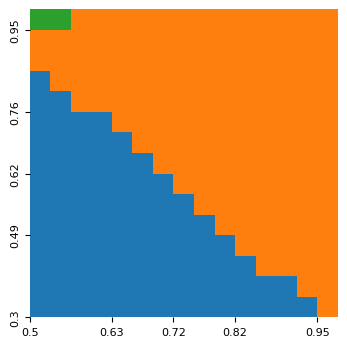

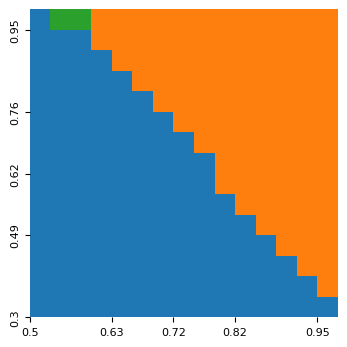

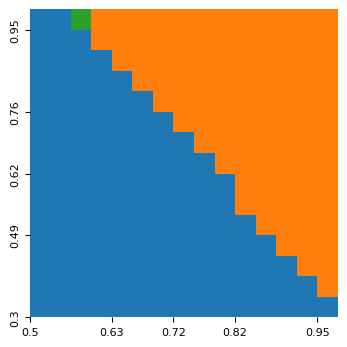

In [15]:
agnostics_bm.perturb_environment(n_iterations=5, plot_bmap=True)

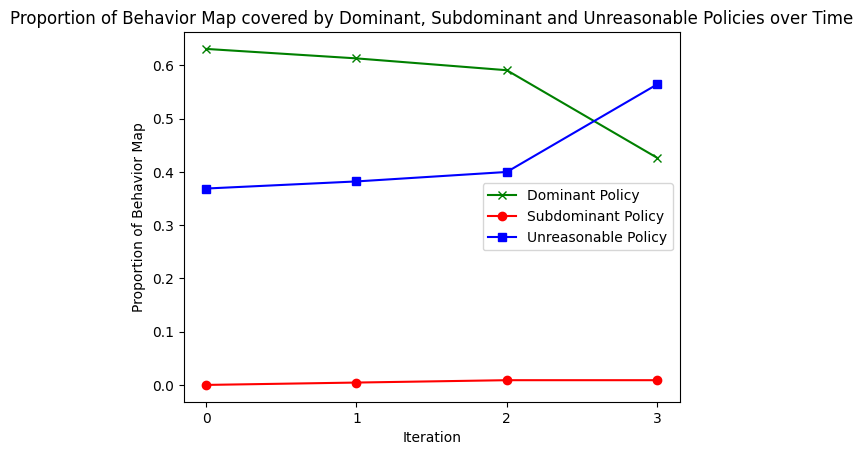

In [16]:
agnostics_bm.plot_props_over_time(3)

In [17]:
agnostics_bm.behavior_map_perturbed_environment

ExperimentResult(data=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32), p2idx={'L': 0, 'DRRRDDDDDRRR': 1, 'RDRDDLDDLD': 2}, pidx2states={0: [0, 0], 1: [0, 7, 8, 9, 10, 17, 24, 31, 38, 45, 46, 47, 48], 2: [0, 1, 8, 9, 16, 23, 

In [18]:
_a1 = 'RDDRDDDDRRRR'
_a2 = 'RDDRDDRRRRDD'

len(_a1) == len(_a2)

True

In [19]:
agnostics_bm.calculate_behavior_map_stats(behavior_map=agnostics_bm.behavior_map_perturbed_environment)

(0.4222222222222222,
 0.0044444444444444444,
 0.5733333333333334,
 [0, 7, 8, 9, 10, 17, 24, 31, 38, 45, 46, 47, 48])

In [20]:
agnostics_bm.behavior_map_perturbed_environment

ExperimentResult(data=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32), p2idx={'L': 0, 'DRRRDDDDDRRR': 1, 'RDRDDLDDLD': 2}, pidx2states={0: [0, 0], 1: [0, 7, 8, 9, 10, 17, 24, 31, 38, 45, 46, 47, 48], 2: [0, 1, 8, 9, 16, 23, 